# Wine Quality Predictions

이 프로젝트는 **Random Forest** 알고리즘을 사용하여 **와인의 품질**을 예측하는 모델을 개발하는 것입니다. 주요 단계는 다음과 같습니다:
1. **Loading the Dataset**: 데이터셋을 로드하고 구조를 이해합니다.
2. **Correlation Analysis**: 품질과 관련된 주요 특성을 찾고, 상관관계를 시각화합니다.
3. **Data Preprocessing**: 불필요한 특성을 제거하고, 품질 값을 이진 분류로 변환합니다.
4. **Building the Models**: Random Forest를 이용하여 모델을 학습합니다.
5. **Hyperparameter Tuning**: GridSearchCV를 사용해 최적의 하이퍼파라미터를 찾습니다.
6. **Model Evaluation**: 학습된 모델을 평가하고 정확도를 계산합니다.

사용할 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Loading the Dataset

먼저, `WineQT.csv` 파일을 읽고 데이터의 구조를 살펴봅니다. 
이를 통해 데이터 타입과 null값 여부를 확인합니다.

In [2]:
# 데이터 로드
df = pd.read_csv('WineQT.csv')

# 데이터 상위 5개 확인
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [3]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


## 2. Correlation Analysis

데이터셋의 특성 간 상관관계를 분석합니다.


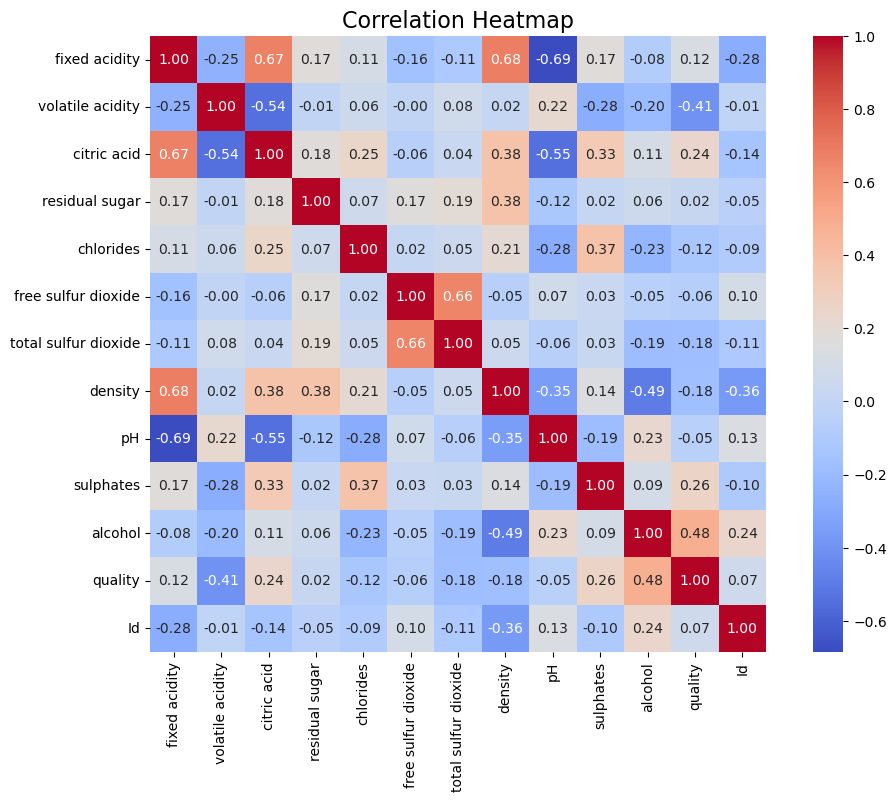

In [4]:
# 상관관계 계산
corr = df.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(12, 8))  
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

## 3. Data Preprocessing

`quality`와 상관관계가 낮은 특성들을 제거하고, `quality` 값을 이진 분류 레이블로 변환합니다.


In [5]:
# quality와 상관계수가 0.1 미만인 특성들 찾기
low_correlation_features = corr['quality'][abs(corr['quality']) < 0.1].index

# 'Id' 열이 포함되어 있을 경우 제거
low_correlation_features = low_correlation_features.append(pd.Index(['Id']))

# 상관계수가 낮은 특성들 제거
df = df.drop(columns=low_correlation_features)

# 제거된 특성들 출력
print(f"Removed Features with Low Correlation: {list(low_correlation_features)}")
print(f"Remaining Features: {list(df.columns)}")

Removed Features with Low Correlation: ['residual sugar', 'free sulfur dioxide', 'pH', 'Id', 'Id']
Remaining Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol', 'quality']


In [6]:
# 품질 값을 이진 레이블로 변환 (0: 저품질, 1: 고품질)
bins = [0, 5, 10] 
labels = [0, 1]   
df["quality_label"] = pd.cut(df["quality"], bins=bins, labels=labels)
df = df.drop(columns=["quality"])

df.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality_label
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,0
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,0
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,0
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,1
4,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,0


## 4. Building the Models

이 단계에서는 Random Forest 모델을 사용하여 품질 예측 모델을 학습시킵니다. 기본 모델을 학습한 후, GridSearchCV를 사용하여 하이퍼파라미터 튜닝을 진행합니다.


In [7]:
# 데이터 나누기
X = df.drop(columns=["quality_label"])
y = df["quality_label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

In [8]:
print(f'train samples: {len(X_train)}\ntest samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 914
test samples: 229
target proportion: 0.5405


# 4.1 기본 Random Forest 모델 학습

In [9]:
# 방법1) 기본 Random Forest 모델 학습
rforest = RandomForestClassifier(random_state=42)
rforest.fit(X_train, y_train)

# 예측 및 정확도 평가
rforest_pred = rforest.predict(X_test)
rforest_acc = accuracy_score(rforest_pred, y_test)
print("Default Random Forest Test accuracy: {:.2f}%".format(rforest_acc * 100))

Default Random Forest Test accuracy: 77.29%


# 4.2 하이퍼파라미터 튜닝

In [10]:
# 방법2) GridSearchCV를 사용한 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [4, 8, 16, None],
    'min_samples_split': [2,10, 30, 50, 100, 200, 300, 700]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 100}


In [11]:
# 최적 모델
best_model = grid_search.best_estimator_

# train & test 정확도
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
test_accuracy = accuracy_score(y_test, best_model.predict(X_test))

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


Training Accuracy: 1.00
Test Accuracy: 0.79


## 6. 결과 요약

- 기본 Random Forest 모델의 테스트 정확도: 약 `77%`
- 하이퍼파라미터 튜닝 후 최적 모델의 테스트 정확도: 약 `79%`

-> 기본 하이퍼파라미터와 최적 하이퍼파라미터의 성능 차이가 크지 않음


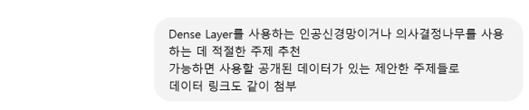
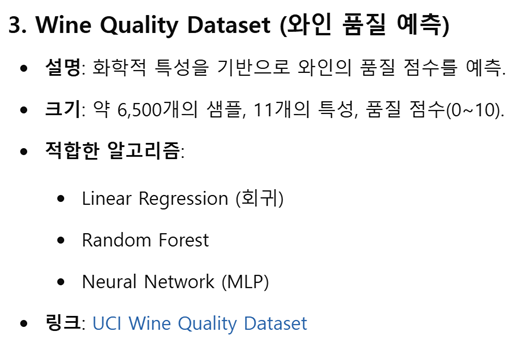
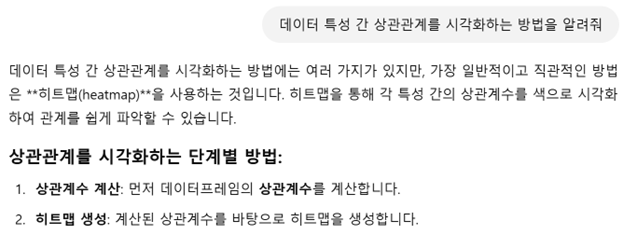
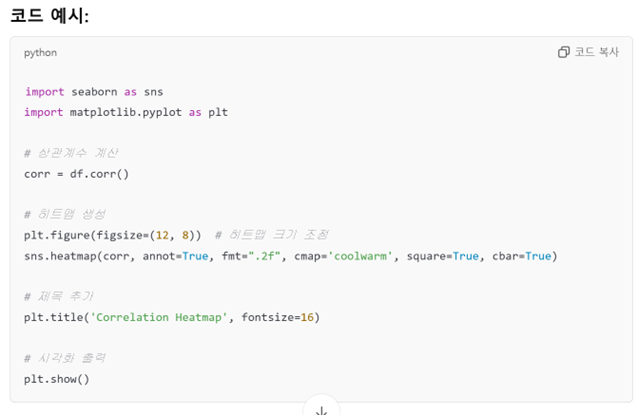
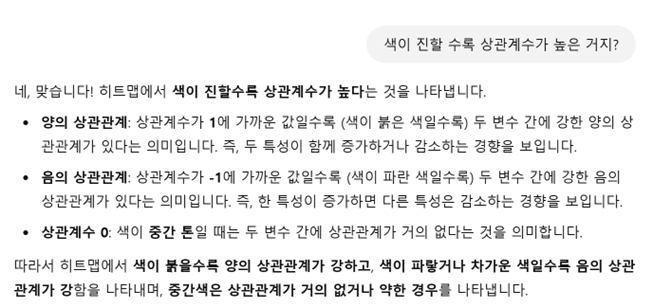
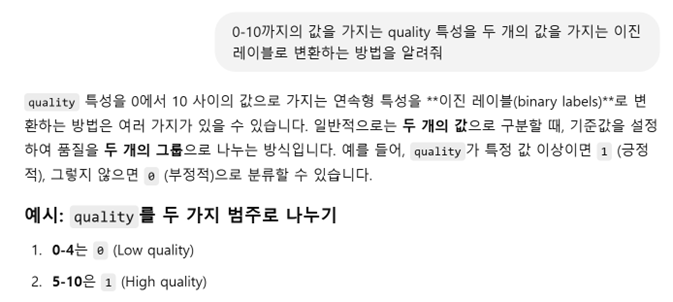
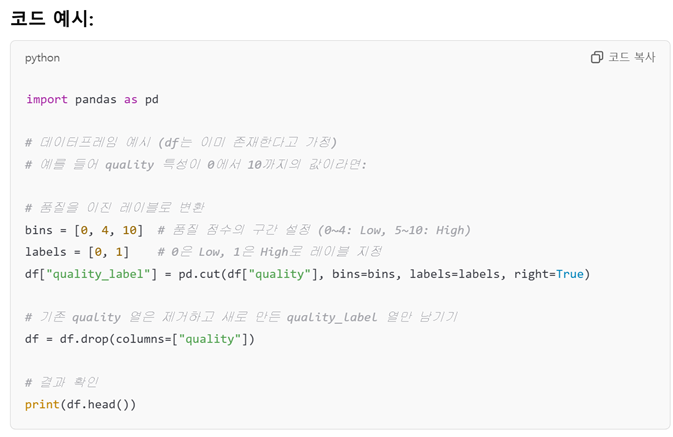
target proportion이 편향되지 않도록 구간 설정을 바꾸어 사용함
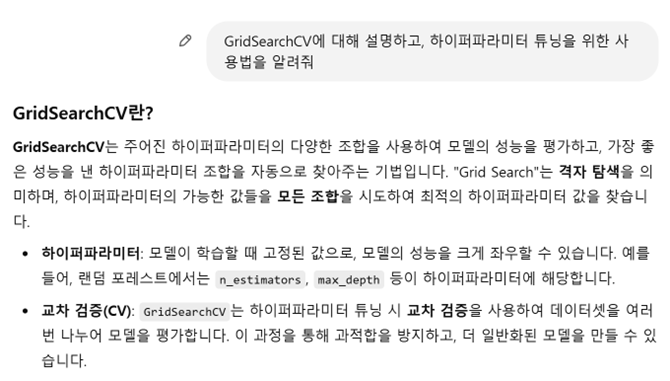
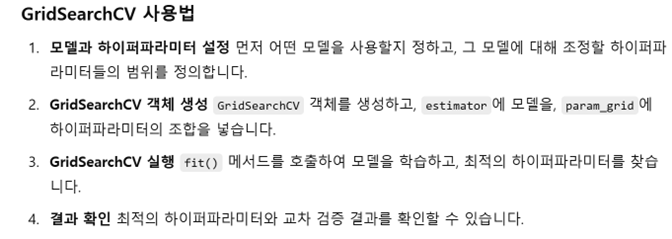
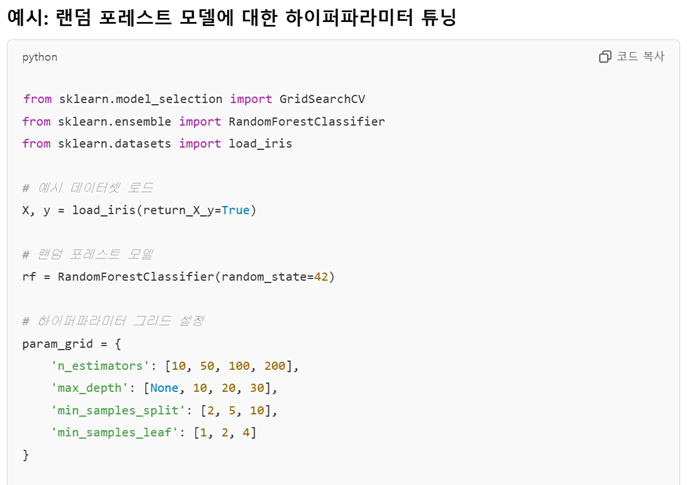
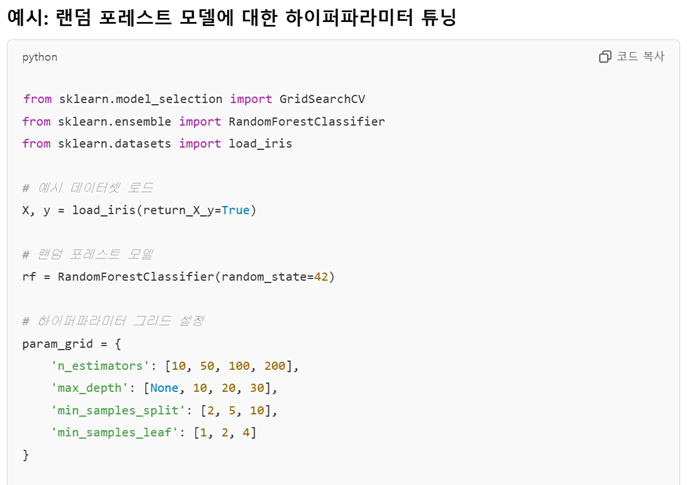
max_depth, min_samples_split, n_estimators 하이퍼파라미터만 최적화에 사용함
그리고 각 리스트를 현재 데이터에 맞춰 수정하여 사용함